<a href="https://www.kaggle.com/code/mustafakapici/heart-failure-prediction?scriptVersionId=182533754" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Hello buddy, Comments are Welcomed, if you have suggestions & questions ? Please add them in discussion section, happy to have conversion with you, Cheers!

![thanks](https://i.imgflip.com/8ngeel.jpg)

# Import data and package stuff (☞ﾟヮﾟ)☞

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna, warnings, random
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

plt.style.use('dark_background')
warnings.simplefilter('ignore', category=FutureWarning)

In [2]:
path='/kaggle/input/predict-survival-of-patients-with-heart-failure/heart_failure_clinical_records_dataset.csv'

df = pd.read_csv(path)

df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [3]:
#drop unnecessary columns
#df.drop(columns=['unnecessary'], inplace=True)

# Data Insights 🧐

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [5]:
pd.DataFrame(df.isna().sum()).T.style.background_gradient(cmap='rainbow')

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
df.describe(percentiles=[0, .25, .30, .50, .75, .80, 1]).T.style.background_gradient(cmap = 'inferno')

,count,mean,std,min,0%,25%,30%,50%,75%,80%,100%,max
age,299.000000,60.833893,11.894809,40.000000,40.000000,51.000000,53.000000,60.000000,70.000000,70.000000,95.000000,95.000000
anaemia,299.000000,0.431438,0.496107,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
creatinine_phosphokinase,299.000000,581.839465,970.287881,23.000000,23.000000,116.500000,130.400000,250.000000,582.000000,620.400000,7861.000000,7861.000000
diabetes,299.000000,0.418060,0.494067,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
ejection_fraction,299.000000,38.083612,11.834841,14.000000,14.000000,30.000000,30.000000,38.000000,45.000000,47.000000,80.000000,80.000000
high_blood_pressure,299.000000,0.351171,0.478136,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
platelets,299.000000,263358.029264,97804.236869,25100.000000,25100.000000,212500.000000,221000.000000,262000.000000,303500.000000,319800.000000,850000.000000,850000.000000
serum_creatinine,299.000000,1.393880,1.034510,0.500000,0.500000,0.900000,1.000000,1.100000,1.400000,1.700000,9.400000,9.400000
serum_sodium,299.000000,136.625418,4.412477,113.000000,113.000000,134.000000,135.000000,137.000000,140.000000,140.000000,148.000000,148.000000
sex,299.000000,0.648829,0.478136,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
def mPlotter(r, c, size, _targets, text):
    
    bg = '#010108'
    
    palette = ['#df5337', '#d24644', '#f7d340', '#3339FF', '#440a68', '#84206b', '#f1ef75', '#fbbe23', '#400a67']
    
    font = 'Comic Sans MS'
    
    fig = plt.figure(figsize=size)
    
    fig.patch.set_facecolor(bg)
    
    grid = fig.add_gridspec(r, c)
    
    grid.update(wspace=0.5, hspace=0.25)
    
    __empty_diff = ((r * c) - 1) - len(_targets)
        
    axes = []
    
    for i in range(r):
        for j in range(c):
            axes.append(fig.add_subplot(grid[i, j]))
    
    for idx, ax in enumerate(axes):
        ax.set_facecolor(bg) 
        
        if idx == 0:
            ax.spines["bottom"].set_visible(False)
            ax.tick_params(left=False, bottom=False)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.text(0.5, 0.5,
                 f'{text}',
                 horizontalalignment='center',
                 verticalalignment='center',
                 fontsize=18, 
                 fontweight='bold',
                 fontfamily=font,
                 color="#fff")
        else:
            if (idx - 1) < len(_targets):
                ax.set_title(_targets[idx - 1].capitalize(), fontsize=14, fontweight='bold', fontfamily=font, color="#fff")
                ax.grid(color='#fff', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
                ax.set_xlabel("")
                ax.set_ylabel("")
            else:
                ax.spines["bottom"].set_visible(False)
                ax.tick_params(left=False, bottom=False)
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        
    def cb(ax):
        ax.set_xlabel("")
        ax.set_ylabel("")
        
    if __empty_diff > 0:
        axes = axes[:-1*__empty_diff]
        
    return axes, palette, cb

In [8]:
target = 'DEATH_EVENT'

cont_cols = df.select_dtypes('number').columns
cont_cols = cont_cols[cont_cols != target]

obj_cols = df.select_dtypes(object).columns

obj_cols = ['anaemia','diabetes','high_blood_pressure','sex','smoking']
len(cont_cols), len(obj_cols)
print(f'Object cols: {obj_cols}')
print(f'Continuous Cols: {cont_cols}')

Object cols: ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
Continuous Cols: Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time'],
      dtype='object')


# Data Visualization 📊

![eda](https://i.imgflip.com/8o7sml.jpg)

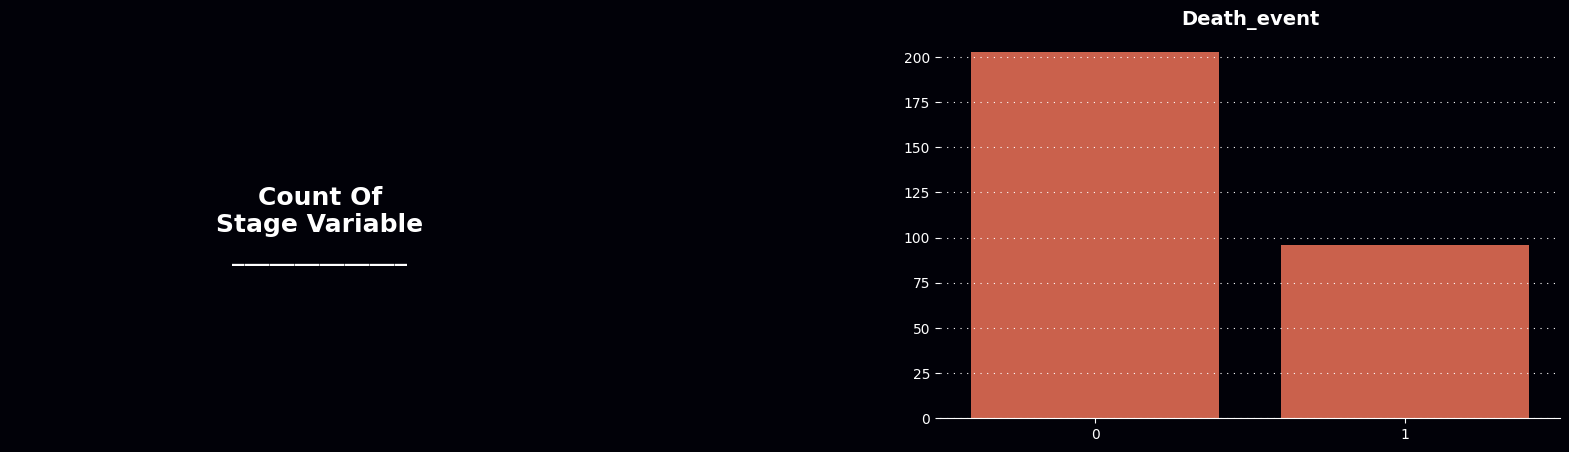

In [9]:
axes, palette, cb = mPlotter(1, 2, (20, 5), [target], 'Count Of\nStage Variable\n______________')

sns.countplot(x=df[target], ax = axes[1], color=palette[0])
cb(axes[1])

/tmp/ipykernel_18/1820082286.py:4: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.kdeplot(data=df, x=col, ax=ax, hue=target, palette=palette[4:7], alpha=.5, linewidth=0, fill=True)
/tmp/ipykernel_18/1820082286.py:4: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.kdeplot(data=df, x=col, ax=ax, hue=target, palette=palette[4:7], alpha=.5, linewidth=0, fill=True)
/tmp/ipykernel_18/1820082286.py:4: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.kdeplot(data=df, x=col, ax=ax, hue=target, palette=palette[4:7], alpha=.5, linewidth=0, fill=True)
/tmp/ipykernel_18/1820082286.py:4: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.kdeplot(data=df, x=col, ax=ax, hue=target, palette=palette[4:7], alpha=.5, linewidth=0, fill=True)
/tmp/ipykernel_18/1820082286.py:4: UserWarning: The palette list

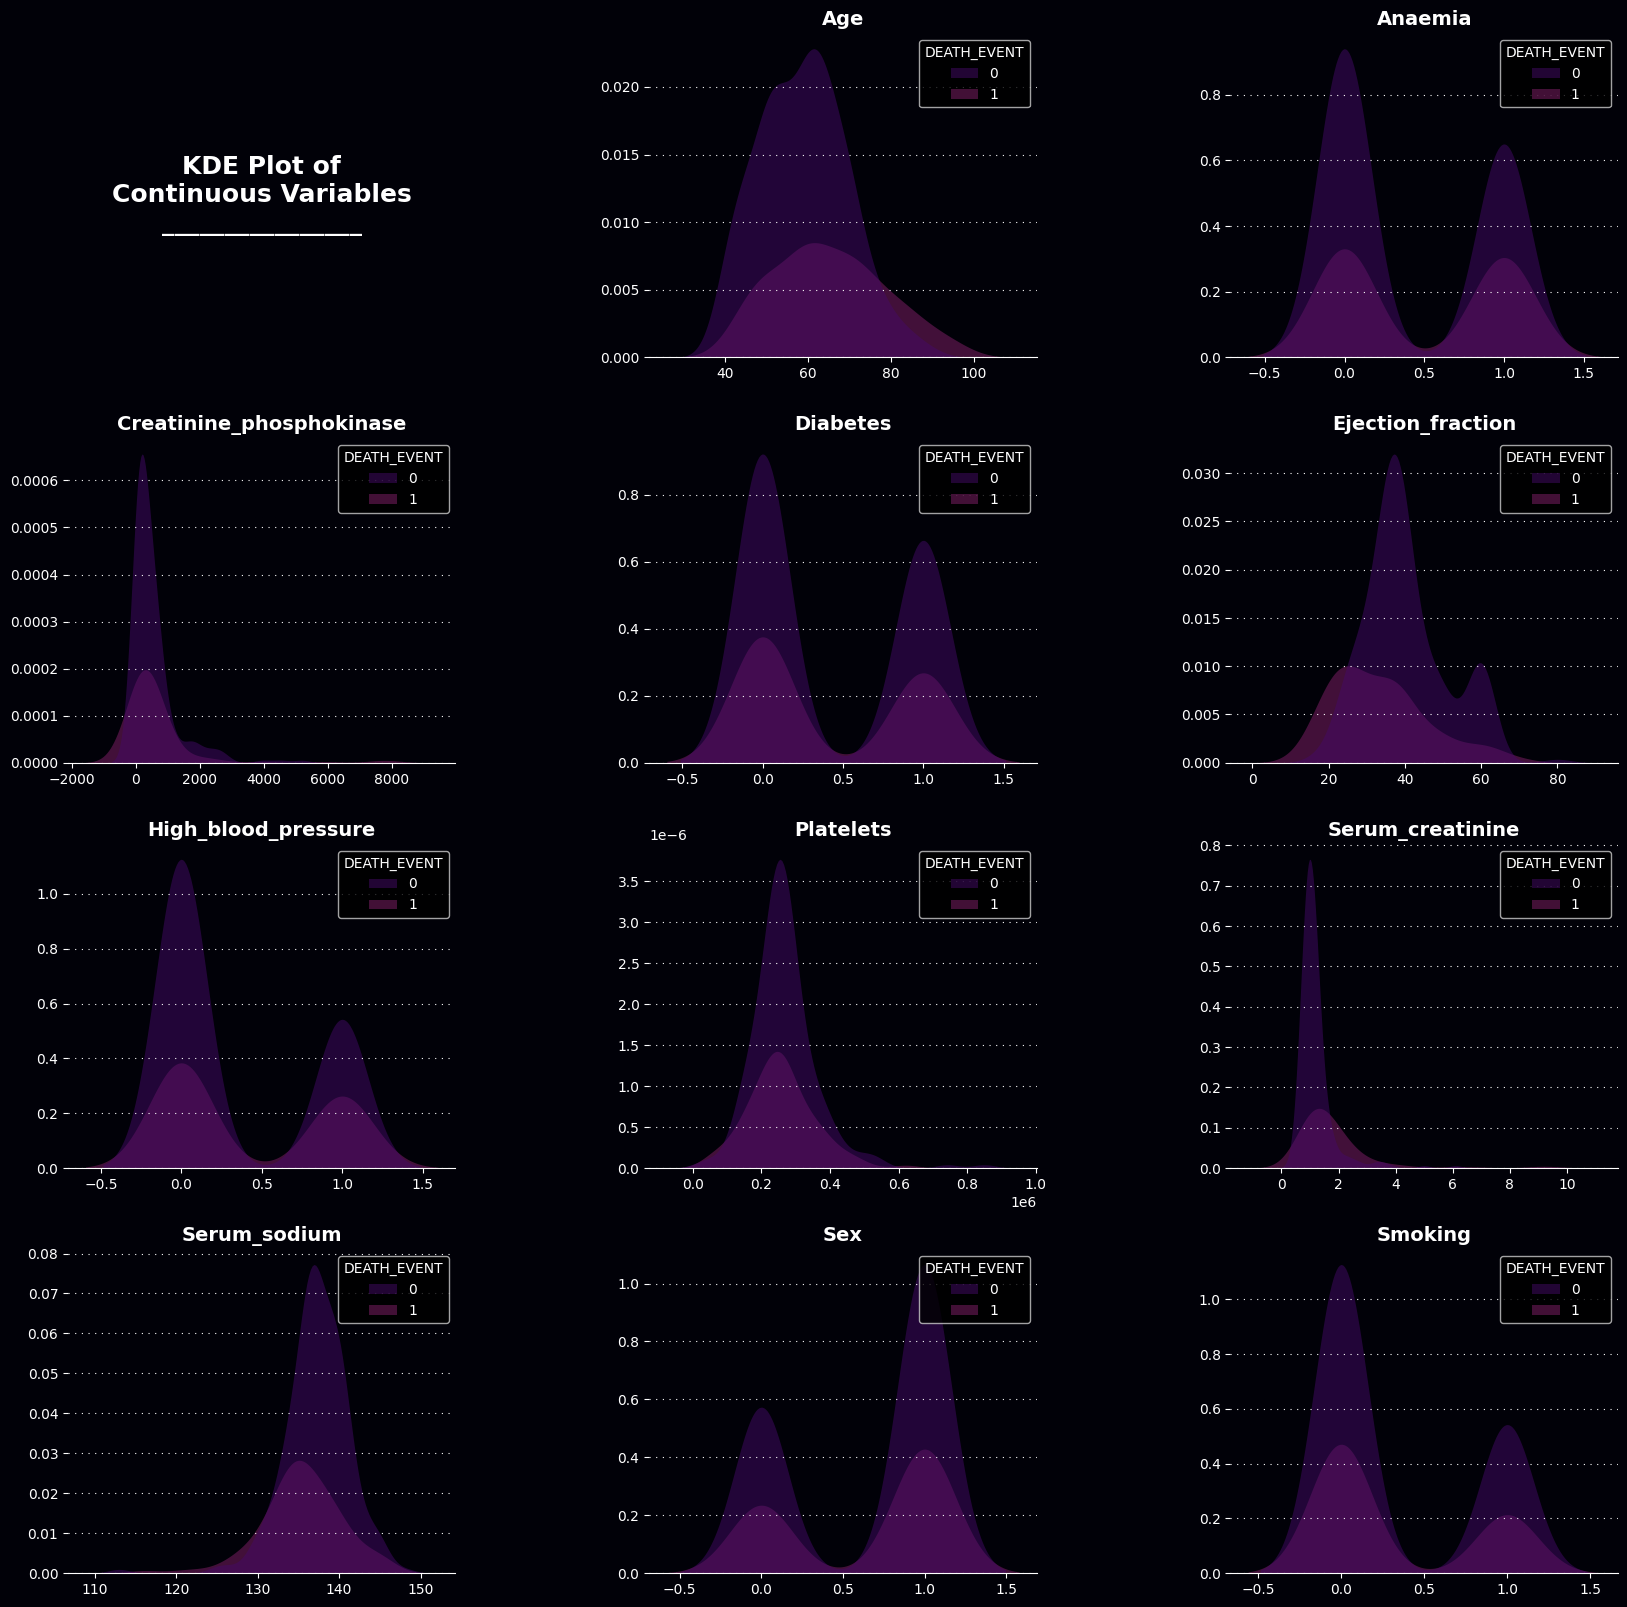

In [10]:
axes, palette, cb = mPlotter(4, 3, (20, 20), cont_cols, 'KDE Plot of\nContinuous Variables\n________________')

for col, ax in zip(cont_cols, axes[1:]):
    sns.kdeplot(data=df, x=col, ax=ax, hue=target, palette=palette[4:7], alpha=.5, linewidth=0, fill=True)
    cb(ax)

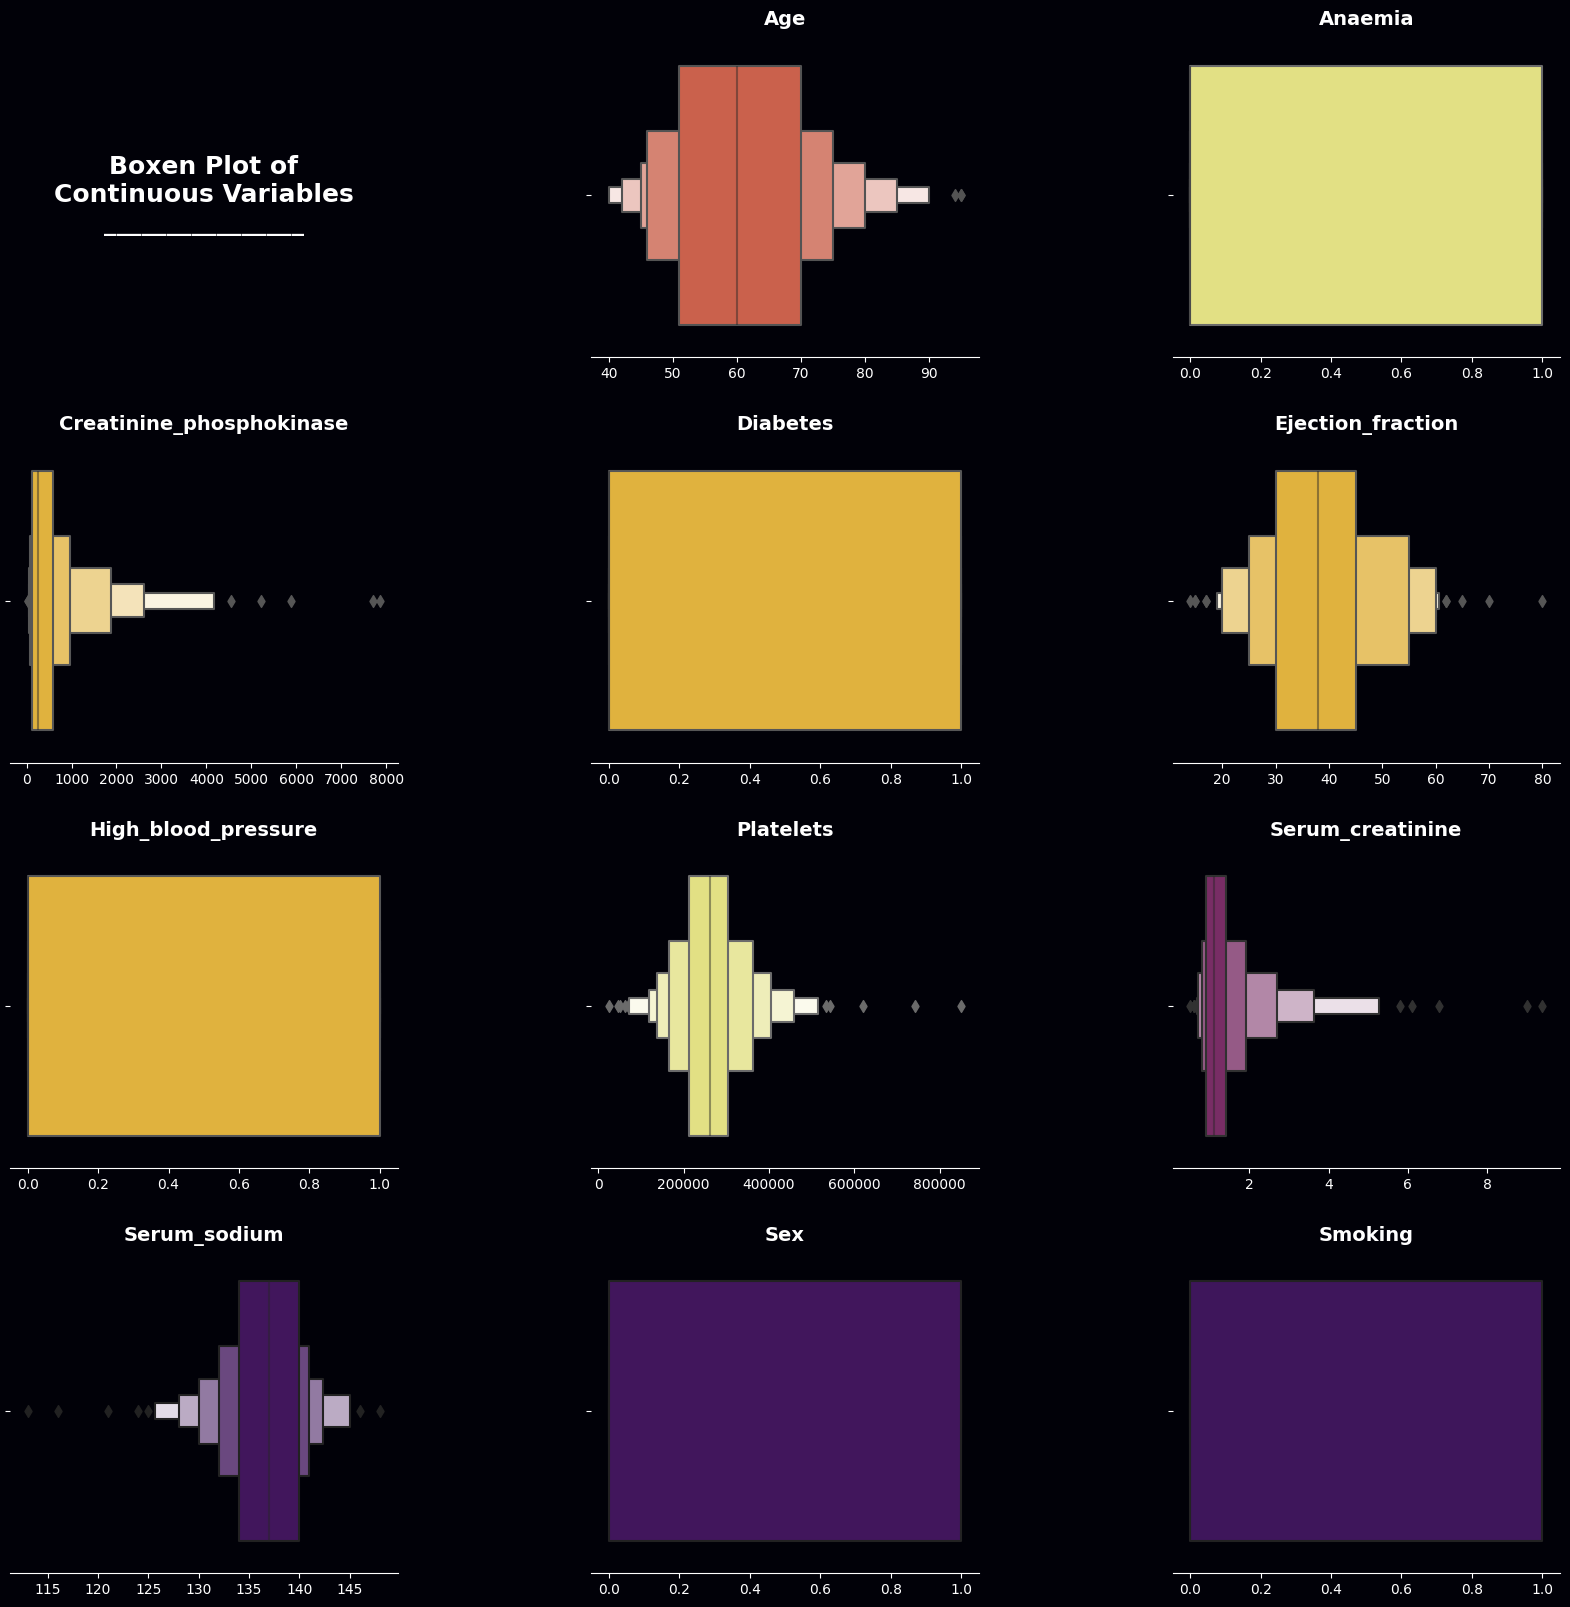

In [11]:
axes, palette, cb = mPlotter(4, 3, (20, 20), cont_cols, 'Boxen Plot of\nContinuous Variables\n________________')

for col, ax in zip(cont_cols, axes[1:]):
    sns.boxenplot(data=df, x=col, ax=ax, palette=[palette[random.randint(0, len(palette)-1)]])
    cb(ax)

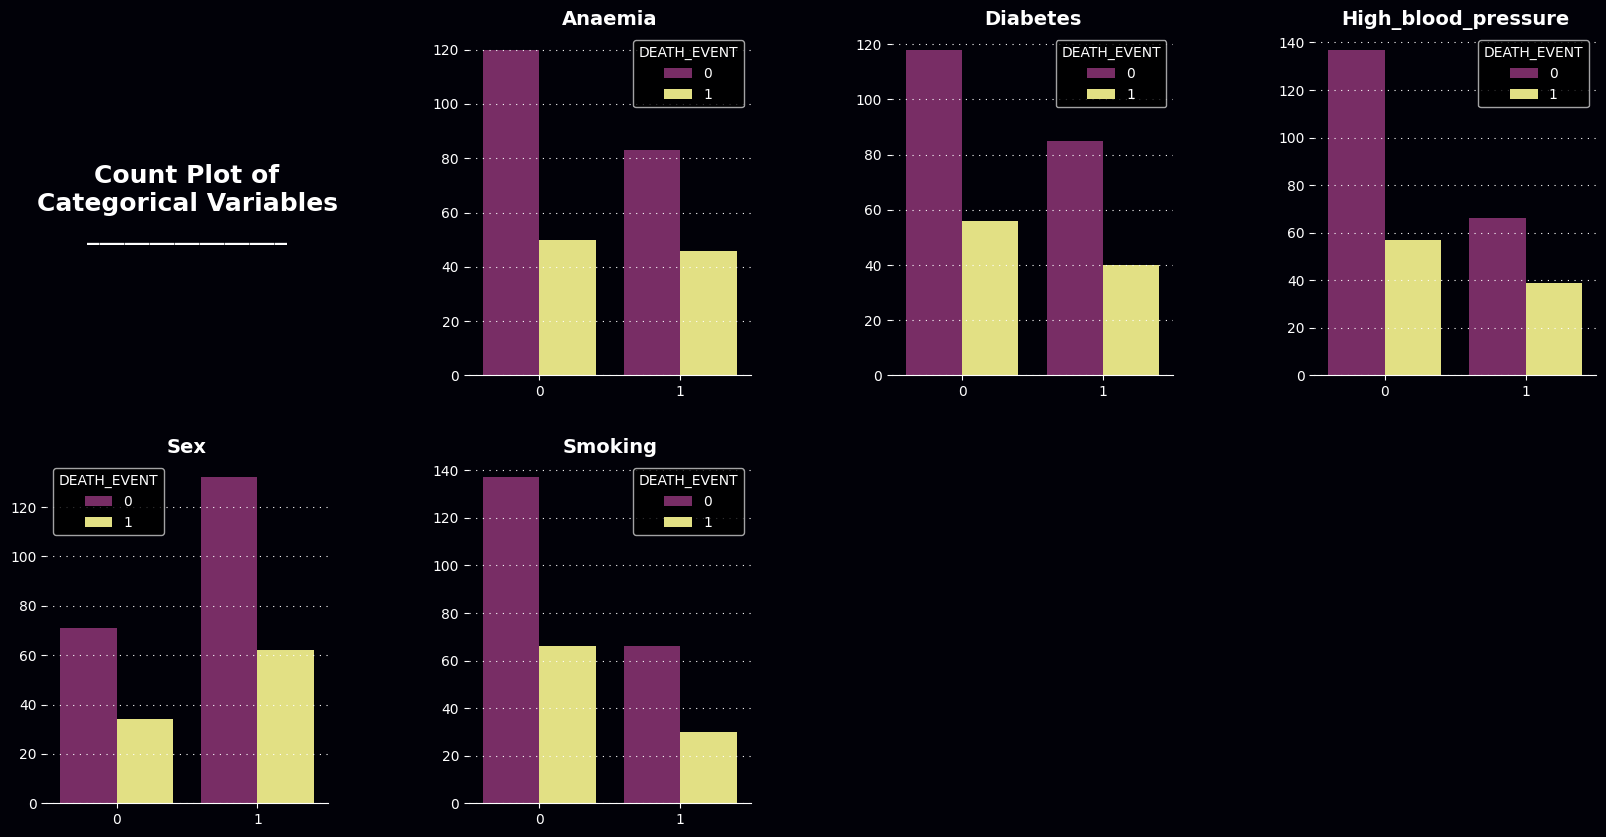

In [12]:
axes, palette, cb = mPlotter(2, 4, (20, 10), obj_cols, 'Count Plot of\nCategorical Variables\n________________')

for col, ax in zip(obj_cols, axes[1:]):
    sns.countplot(data=df, x=col, ax=ax, hue=target, palette=palette[5:7])
    cb(ax)

In [13]:
ax = px.scatter_3d(df, x="time", y="platelets", z="creatinine_phosphokinase", template= "plotly_dark", color=target, title="3D Scatter Plot of Continuous Variables")

ax.show()

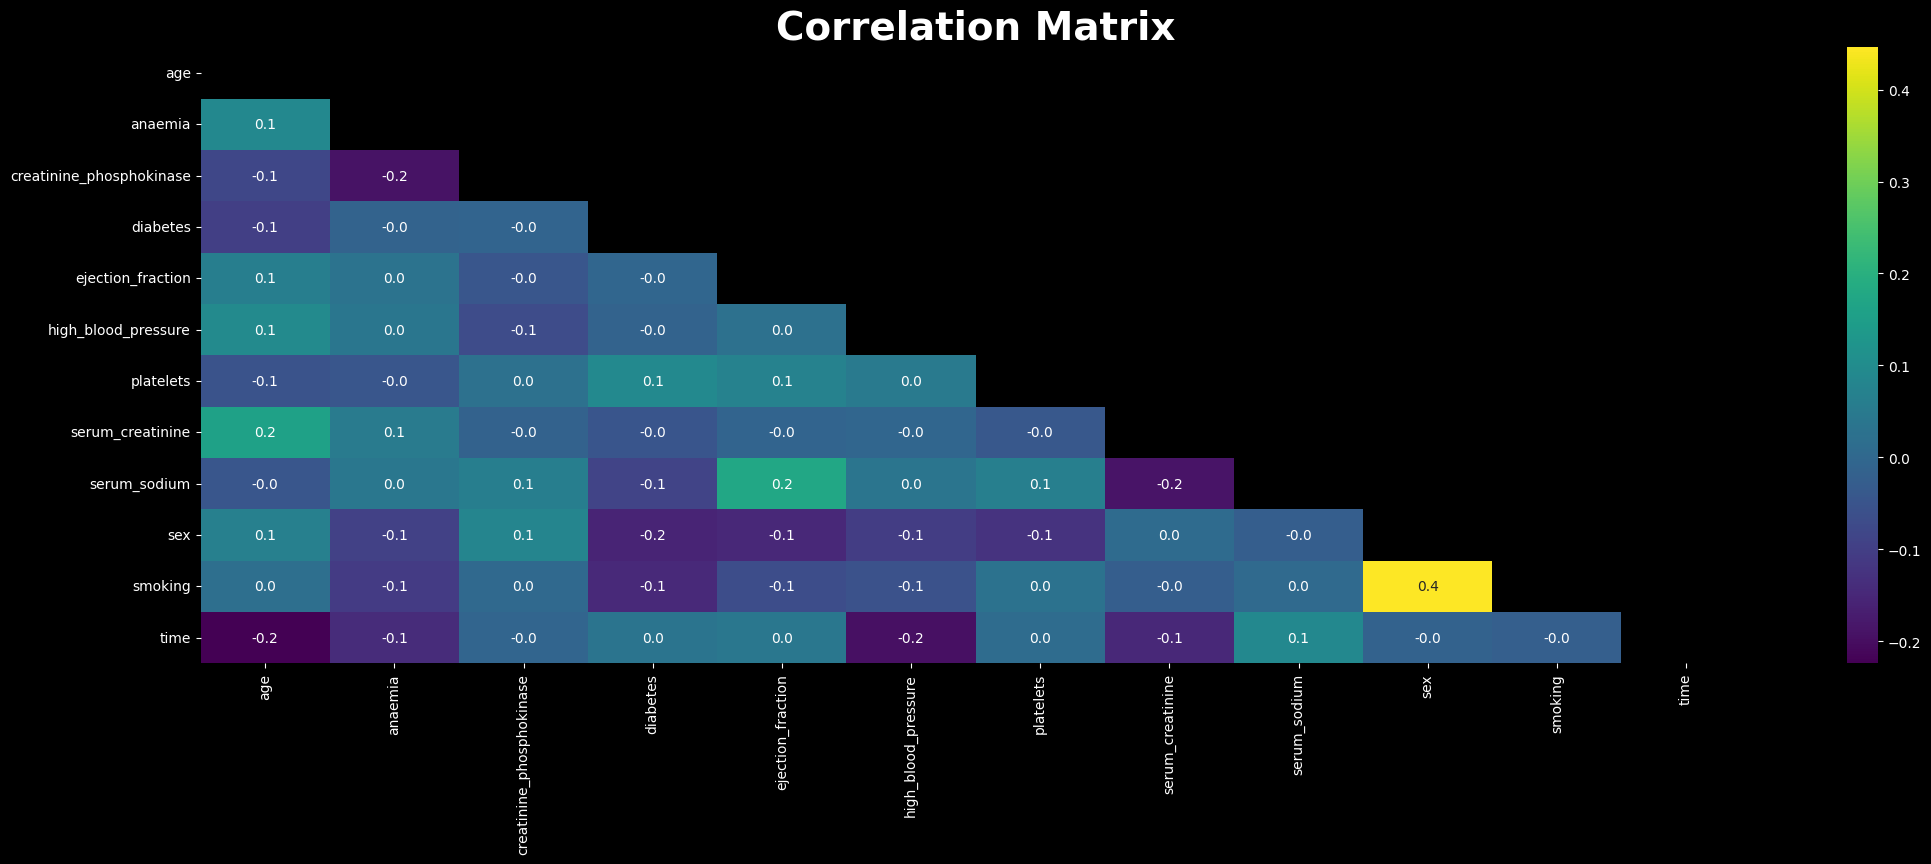

In [14]:
fig = plt.figure(figsize=(25, 8))

gs = fig.add_gridspec(1, 1)

gs.update(wspace=0.3, hspace=0.15)

ax = fig.add_subplot(gs[0, 0])

ax.set_title("Correlation Matrix", fontsize=28, fontweight='bold', fontfamily='Comic Sans MS', color="#fff")

sns.heatmap(df[cont_cols].corr().transpose(), mask=np.triu(np.ones_like(df[cont_cols].corr().transpose())), fmt=".1f", annot=True, cmap='viridis')

plt.show()

In [15]:
for col in df.select_dtypes(object):
    df[col] = LabelEncoder().fit_transform(df[col])
    
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


# Split the cakes equal 🍰

In [16]:
le = LabelEncoder()
df[target] = le.fit_transform(df[target])


In [17]:
X = df.drop(columns=[target], axis=1)
y = df[target].values

In [18]:
X.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8


In [19]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((209, 12), (90, 12), (209,), (90,))

# Scale the data to ground 🌄

In [21]:
X_train = MinMaxScaler().fit_transform(X_train)
X_test = MinMaxScaler().fit_transform(X_test)

# The Black Magic 🧿

![model](https://i.imgflip.com/8o7ssy.jpg)

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0),
    'KNN': KNeighborsClassifier(),
    #'Neural Network': MLPClassifier(),
    #'LGBM': LGBMClassifier(),
    'Voting Classifier': VotingClassifier(
        estimators=[
            ('cat', CatBoostClassifier(verbose=0)), 
            ('xg', XGBClassifier()), 
            ('lgbm', LGBMClassifier(verbose=-1))],
    voting='soft',
    verbose=False
)
}


params={
    'Logistic Regression': {'C': [0.1, 1, 10, 100], 'solver': ['liblinear'], 'max_iter': [200]},
    'Decision Tree': {'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, 7, 9, 11, 13]},
    'Random Forest': {'n_estimators': [100, 300, 500], 'max_depth': [3, 5, 7, 9, 11, 13]},
    'KNN': {'n_neighbors': [3, 5, 7, 9 , 13], 'weights': ['uniform', 'distance']},
    'Naive Bayes': { 'var_smoothing': [1e-9, 1e-8, 1e-7]},
    'Neural Network': {'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100)], 
                       'activation': ['logistic', 'tanh', 'relu'],
                       'solver': ['adam'], 'alpha': [0.0001, 0.001, 0.01],
                       'max_iter': [ 500, 1000,2000]},
    'XGBoost': {'n_estimators': [100, 300, 500], 'max_depth': [3, 5, 7, 9, 11, 13]},
    'LGBM': {'n_estimators': [100, 300, 500], 'max_depth': [3, 5, 7, 9, 11, 13]},
    'CatBoost': {'iterations': [100, 300, 500], 'depth': [3, 5, 7, 9, 11, 13]},
    'Voting Classifier': {}
}

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score , f1_score ,classification_report

# Train function
def train_model(X_train, y_train, models, params):
    best_estimators = {}
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=params[model_name],
            scoring='accuracy',
            cv=5, n_jobs=-1
        )
        
        grid_search.fit(X_train, y_train)
        best_estimators[model_name] = grid_search.best_estimator_
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        print(f"Best score for {model_name}: {grid_search.best_score_}\n")
    return best_estimators

# Evaluate function
def evaluate_model(X_test, y_test, models):
    classification_reports = {}

    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

       

        classification_rep = classification_report(y_test, y_pred)

       

        classification_reports[model_name] = classification_rep

    return  classification_reports

In [24]:
# Train the models
best_models = train_model(X_train, y_train, models, params)

Training Logistic Regression...
Best parameters for Logistic Regression: {'C': 100, 'max_iter': 200, 'solver': 'liblinear'}
Best score for Logistic Regression: 0.8419279907084786

Training Decision Tree...
Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 5}
Best score for Decision Tree: 0.8326364692218352

Training Random Forest...
Best parameters for Random Forest: {'max_depth': 5, 'n_estimators': 100}
Best score for Random Forest: 0.8806039488966318

Training Naive Bayes...
Best parameters for Naive Bayes: {'var_smoothing': 1e-09}
Best score for Naive Bayes: 0.7847851335656214

Training XGBoost...
Best parameters for XGBoost: {'max_depth': 5, 'n_estimators': 500}
Best score for XGBoost: 0.8806039488966318

Training CatBoost...


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Best parameters for CatBoost: {'depth': 9, 'iterations': 100}
Best score for CatBoost: 0.8710801393728224

Training KNN...
Best parameters for KNN: {'n_neighbors': 9, 'weights': 'uniform'}
Best score for KNN: 0.7226480836236935

Training Voting Classifier...
Best parameters for Voting Classifier: {}
Best score for Voting Classifier: 0.8567944250871079



In [25]:
# Evaluate the best models
classification_reports = evaluate_model(X_test, y_test, best_models)

Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating Random Forest...
Evaluating Naive Bayes...
Evaluating XGBoost...
Evaluating CatBoost...
Evaluating KNN...
Evaluating Voting Classifier...


# Oversee the model performance 👀

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# Print classification reports
for model_name, report in classification_reports.items():
    print(f"\nClassification Report for {model_name}:\n{report}")


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.70      0.94      0.81        53
           1       0.84      0.43      0.57        37

    accuracy                           0.73        90
   macro avg       0.77      0.69      0.69        90
weighted avg       0.76      0.73      0.71        90


Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.67      0.89      0.76        53
           1       0.70      0.38      0.49        37

    accuracy                           0.68        90
   macro avg       0.69      0.63      0.63        90
weighted avg       0.68      0.68      0.65        90


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        53
           1       0.88      0.57      0.69        37

    accuracy                           0.79       

![thanksagain](https://i.imgflip.com/8ou6ip.jpg)

![thanksagain](https://i.imgflip.com/8o7tp4.jpg)

#  Any suggestion to improve performance are welcomed.